<a href="https://colab.research.google.com/github/deepsharma26/SIRT1_Main/blob/Unknown_dataset_predictions/Unknown_predictions_QDA%2Bsmote%2Bgnoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediction of unknown dataset (NPASS-96235 compounds)

Rebuilding the previous model (QDA + smote + gnoise) for loading into pickle module

In [1]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, mean_absolute_error, cohen_kappa_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd

In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, cohen_kappa_score,
    mean_absolute_error, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

Original dataset shape: Counter({0: 792, 1: 141})
Resampled dataset shape (SMOTE + noise): Counter({1: 792, 0: 792})

Accuracy: 0.7710084033613446
Balanced Accuracy: 0.7710084033613446
F1 Score: 0.7789046653144016
Cohen's Kappa: 0.5420168067226891
Mean Absolute Error: 0.22899159663865545

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.76       238
           1       0.75      0.81      0.78       238

    accuracy                           0.77       476
   macro avg       0.77      0.77      0.77       476
weighted avg       0.77      0.77      0.77       476


Confusion Matrix:
 [[175  63]
 [ 46 192]]


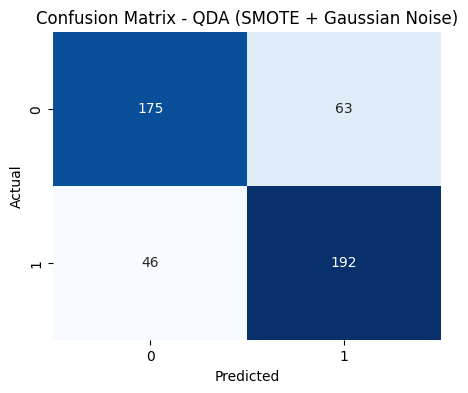

ROC AUC: 0.8559247228303086


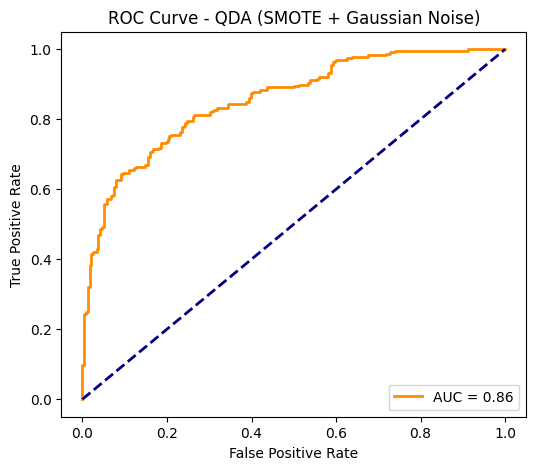

In [5]:
df = pd.read_csv("/content/MACCS2_Trainset_top20.csv")
X = df.drop("BioactivityClass", axis=1)
y = df["BioactivityClass"]

print("Original dataset shape:", Counter(y))


smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)


noise = np.random.normal(0, 0.01, X_smote.shape)
X_smote_noisy = X_smote + noise

print("Resampled dataset shape (SMOTE + noise):", Counter(y_smote))

X_train, X_test, y_train, y_test = train_test_split(
    X_smote_noisy, y_smote, test_size=0.3, random_state=42, stratify=y_smote
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)


y_pred = qda.predict(X_test_scaled)
y_proba = qda.predict_proba(X_test_scaled)[:, 1] if len(qda.classes_) == 2 else None


print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - QDA (SMOTE + Gaussian Noise)")
plt.show()

if y_proba is not None:
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC:", roc_auc)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - QDA (SMOTE + Gaussian Noise)")
    plt.legend(loc="lower right")
    plt.show()

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(qda, X_smote_noisy, y_smote, cv=skf, scoring='accuracy')

print(f"Stratified K-Fold Accuracy: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores)} ± {np.std(cv_scores)}")

Stratified K-Fold Accuracy: [0.81761006 0.75471698 0.78616352 0.7672956  0.75949367 0.81012658
 0.78481013 0.8164557  0.78481013 0.78481013]
Mean Accuracy: 0.7866292492635936 ± 0.021307790817267837


Loading the build model and screening unknown dataset

In [8]:
import pickle

# Save model
with open("qda_smote_gnoise_model.pkl", "wb") as model_file:
    pickle.dump(qda, model_file)

# Load model
with open("qda_smote_gnoise_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

# Test loaded model
y_pred_loaded = loaded_model.predict(X_test_scaled)
print(f"Loaded Model Accuracy: {accuracy_score(y_test, y_pred_loaded)}")

Loaded Model Accuracy: 0.7710084033613446


In [9]:
import pandas as pd

# Load unknown data
unknown_df = pd.read_csv("/content/MACCS_with_SMILES_merged_96235_top20_csv.csv")

In [10]:
# Get the feature names used during training
training_features = X.columns

# Select only the necessary columns from unknown_df, and reorder them
unknown_df = unknown_df.reindex(columns=training_features)

In [12]:
# Fill any potential NaN values with 0 (or another appropriate imputation strategy)
unknown_df = unknown_df.fillna(0)

# Scale the unknown data using the same scaler fitted on the training data
unknown_df_scaled = scaler.transform(unknown_df)

# Predict class labels
predictions = loaded_model.predict(unknown_df_scaled)

# Predict probabilities (if needed)
probabilities = loaded_model.predict_proba(unknown_df_scaled)

original_unknown_df = pd.read_csv("/content/MACCS_with_SMILES_merged_96235_top20_csv.csv")
SMILES = original_unknown_df["SMILES"]

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame({
    "SMILES": SMILES,
    "Predicted_Class": predictions,
    "Probability_Class_0": probabilities[:, 0],  # Probability of class 0
    "Probability_Class_1": probabilities[:, 1]   # Probability of class 1
})

# Save predictions
predictions_df.to_csv("Unknown_predictions_qda_smote+gnoise.csv", index=False)
print("Predictions saved to Unknown_predictions_qda_smote+gnoise.csv")

Predictions saved to Unknown_predictions_qda_smote+gnoise.csv
